1. Get the Basin parameters per run
2. Get the DSS results. 
3. Filter the result. Retain only the dates with observed streamflow data
4. Compute the mean of observed data
5. compute the Observed - Predicted
6. Compute the NSE for the run

In [234]:
import os, datetime
import numpy as np
import pandas as pd
from pydsstools.heclib.dss import HecDss
from matplotlib import pyplot as plt

In [235]:
# User defined inputs

# HMS File Paths
hms_project_directory = r"D:\AMH Philippines, Inc\EDC Projects - 20 NP24.XXX Amacan Water Balance HH\06 WORK FILES\05 HEC HMS\hms_edc_amacan_rdtc_calib"
hms_basin_name = 'EDC_Basin'
hms_dss_name = 'edc_run_v1'

# Observed Streamflow Data File path
xl_path = r"D:\AMH Philippines, Inc\EDC Projects - 20 NP24.XXX Amacan Water Balance HH\06 WORK FILES\05 HEC HMS\hms_edc_amacan_rdtc_calib\NSE_computation\observed_data.xlsx"

# ---- Working File Paths ----
hms_basin_path = os.path.join(hms_project_directory, f'{hms_basin_name}.basin')
hms_dss_path = os.path.join(hms_project_directory, f'{hms_dss_name}.dss')
csv_save_path = os.path.join(hms_project_directory, 'NSE_computation', 'NSE.csv')

print(f'HMS Project Directory: {os.path.basename(hms_project_directory)}')
print(f'HMS Working Basin File: {os.path.basename(hms_basin_path)}')
print(f'HMS Working DSS File: {os.path.basename(hms_dss_path)}')
print(f'HMS CSV Save File: {os.path.basename(csv_save_path)}')

HMS Project Directory: hms_edc_amacan_rdtc_calib
HMS Working Basin File: EDC_Basin.basin
HMS Working DSS File: edc_run_v1.dss
HMS CSV Save File: NSE.csv


In [238]:
# Define Functions

def parse_subbasin_reach(filepath):
    """
    Parses a text file with Subbasin and Reach blocks into a pandas DataFrame.
    """
    records = []
    current = None
    in_code = False

    with open(filepath, 'r') as f:
        for raw in f:
            line = raw.strip()
            
            # Detect new block
            if line.startswith(('Subbasin:', 'Reach:')):
                if current:
                    records.append(current)
                kind, name = line.split(':', 1)
                current = {'type': kind, 'name': name.strip()}
                in_code = False
                continue
            
            # Toggle code block on/off
            if line == '```':
                in_code = not in_code
                continue
            
            # End of block
            if line == 'End:':
                if current:
                    records.append(current)
                current = None
                in_code = False
                continue
            
            # Within a block, parse any "Key: Value" lines
            if ':' in line and current is not None:
                key, val = line.split(':', 1)
                col = key.strip().lower().replace(' ', '_').replace('-', '_')
                current[col] = val.strip()

    df = pd.DataFrame(records)
    df = df[['type', 'name', 'area', 'downstream',
       'discretization', 'canopy', 'allow_simultaneous_precip_et',
       'plant_uptake_method', 'initial_canopy_storage_percent',
       'canopy_storage_capacity', 'crop_coefficient', 'surface', 'initial_surface_storage_percent',
       'surface_storage_capacity', 'surface_albedo',
       'lossrate', 'percent_impervious_area',
       'initial_soil_storage_percent', 'initial_gw1_storage_percent',
       'initial_gw2_storage_percent', 'soil_maximum_infiltration',
       'soil_storage_capacity', 'soil_tension_capacity',
       'soil_maximum_percolation', 'groundwater_1_storage_capacity',
       'groundwater_1_routing_coefficient',
       'groundwater_1_maximum_percolation',
       'groundwater_2_storage_capacity',
       'groundwater_2_routing_coefficient',
       'groundwater_2_maximum_percolation', 'transform', 'lag',
       'unitgraph_type', 'baseflow', 'recession_factor',
       'initial_baseflow', 'threshold_flow_to_peak_ratio', 'route',
       'initial_variable', 'channel_loss']]
    return df

def save_with_sequential_run_id(df, master_csv=csv_save_path):
    """
    Appends df to master_csv, tagging each row with a run_id of the form 'Run N',
    where N is one greater than the highest existing run number in master_csv.
    """
    if not os.path.exists(os.path.dirname(master_csv)):
        os.makedirs(os.path.dirname(master_csv))

    # 1) Determine the next run number
    if os.path.exists(master_csv):
        # Read just the run_id column (faster than whole file)
        existing = pd.read_csv(master_csv, usecols=["run_id"])
        # Extract numbers from strings like 'Run 3'
        nums = existing["run_id"].dropna().str.extract(r"Run\s+(\d+)", expand=False)
        nums = pd.to_numeric(nums, errors="coerce").dropna()
        next_run = int(nums.max()) + 1 if not nums.empty else 1
    else:
        next_run = 1

    run_id = f"Run {next_run}"
    
    # 2) Tag the DataFrame
    df = df.copy()
    df["run_id"] = run_id

    # 3) Append (or create) the master CSV
    header = not os.path.exists(master_csv)
    df.to_csv(master_csv, mode="a", index=False, header=header)

    return run_id

# Assigns NSE Values per run
def compute_nse_per_run(df, run_id):
    mapping = {
        'Bunlang EP': ['Bunlang Catchment 1', 'Bunlang Catchment 2'],
        'Masara EP':  ['Masara Catchment'],
        'Simsimin Catchment': ['Simsimin Catchment']
    }

    extraction_points = ['Bunlang EP', 'Masara EP', 'Simsimin Catchment']
    subbasins = ['Bunlang Creek', 'Masara River', 'Simsimin Creek']
    with HecDss.Open(hms_dss_path) as dss:
        for extraction_point, subbasin in zip(extraction_points, subbasins):
            dss_pathname = f'//{extraction_point}/FLOW/01Jan2025/1Day/RUN:edc_run_v1/'
            startDate = '02Feb2025 00:00:00'
            endDate = '08Apr2025 00:00:00'

            # Read the Time-Series Data
            ts = dss.read_ts(dss_pathname, 
                            window=(startDate, endDate),
                            trim_missing=True)
            times = np.array(ts.pytimes)
            values = ts.values
            
            # Store the Time-Series in a DataFrame
            df_time_series = pd.DataFrame({'date': times, 'pred_value': values})
            
            # Filter only the observed dates
            allowed = [
                "03/02/2025","07/02/2025","10/02/2025","12/02/2025","14/02/2025","17/02/2025",
                "19/02/2025","03/03/2025","05/03/2025","07/03/2025","12/03/2025","17/03/2025",
                "24/03/2025","26/03/2025","28/03/2025","31/03/2025","02/04/2025","07/04/2025"
            ]
            
            # Convert list to datetime format
            allowed = pd.to_datetime(allowed, dayfirst=True)

            # Filter the DataFrame
            df_filtered = df_time_series[df_time_series['date'].isin(allowed)].reset_index(drop=True)

            # Merge DataFrame

            # Filter observed data - retain Bulang Creek
            df_obs_filtered = df_obs[df_obs['extraction_point'] == subbasin]

            # Merged two DataFrames
            df_merged = pd.merge(df_obs_filtered, 
                                        df_filtered,
                                        on=['date'])

            # NSE Computation
            mean_obs = df_merged['discharge'].mean()
            num = ((df_merged['discharge'] - df_merged['pred_value'])**2).sum()
            den = ((df_merged['discharge'] - mean_obs)**2).sum()
            nse = 1 - num/den

            print(f'NSE Value for {extraction_point}: {nse}')

            names_to_update = mapping[extraction_point]
            mask = (
                (df['run_id'] == run_id) &
                (df['name'].isin(names_to_update))
            )
            df.loc[mask, 'nse'] = nse
            print(f"Assigned NSE={nse:.4f} to {names_to_update}")
    return df.to_csv(csv_save_path, index=False)

# ---- Plot Flows ----
def plot_current_run(df):

    extraction_points = ['Bunlang EP', 'Masara EP', 'Simsimin Catchment']
    subbasins         = ['Bunlang Creek', 'Masara River', 'Simsimin Creek']

    # 1) Create a 2×2 grid of axes
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    with HecDss.Open(hms_dss_path) as dss:
        for i, (extraction_point, subbasin) in enumerate(zip(extraction_points, subbasins)):
            ax = axes[i]

            # --- load & merge exactly as before ---
            dss_path = f'//{extraction_point}/FLOW/01Jan2025/1Day/RUN:edc_run_v1/'
            ts = dss.read_ts(dss_path, window=('02Feb2025 00:00:00','08Apr2025 00:00:00'), trim_missing=True)
            df_ts = pd.DataFrame({'date': np.array(ts.pytimes), 'pred_value': ts.values})
            allowed = pd.to_datetime([
                "03/02/2025","07/02/2025","10/02/2025","12/02/2025","14/02/2025","17/02/2025",
                "19/02/2025","03/03/2025","05/03/2025","07/03/2025","12/03/2025","17/03/2025",
                "24/03/2025","26/03/2025","28/03/2025","31/03/2025","02/04/2025","07/04/2025"
            ], dayfirst=True)
            df_filt = df_ts[df_ts['date'].isin(allowed)].reset_index(drop=True)
            df_obs_f = df_obs[df_obs['extraction_point'] == subbasin]
            df_merged = pd.merge(df_obs_f, df_filt, on='date').set_index('date')

            # 2) scatter observed, line+marker simulated
            ax.scatter(
                df_merged.index,
                df_merged['discharge'],
                marker='+',
                label=f'Obs @ {subbasin}'
            )
            ax.plot(
                df_merged.index,
                df_merged['pred_value'],
                '-+',
                label=f'Sim @ {subbasin}'
            )

            ax.set_title(subbasin)
            ax.set_xlabel('Date')
            ax.set_ylabel('Discharge')
            ax.legend(fontsize='small')

    # Hide the unused subplot (bottom-right)
    axes[-1].set_visible(False)

    fig.tight_layout()
    plt.show()
    return fig, ax


Run 1
NSE Value for Bunlang EP: -33.39459421257334
Assigned NSE=-33.3946 to ['Bunlang Catchment 1', 'Bunlang Catchment 2']
NSE Value for Masara EP: -104.25467371110601
Assigned NSE=-104.2547 to ['Masara Catchment']
NSE Value for Simsimin Catchment: -22.711517485328955
Assigned NSE=-22.7115 to ['Simsimin Catchment']


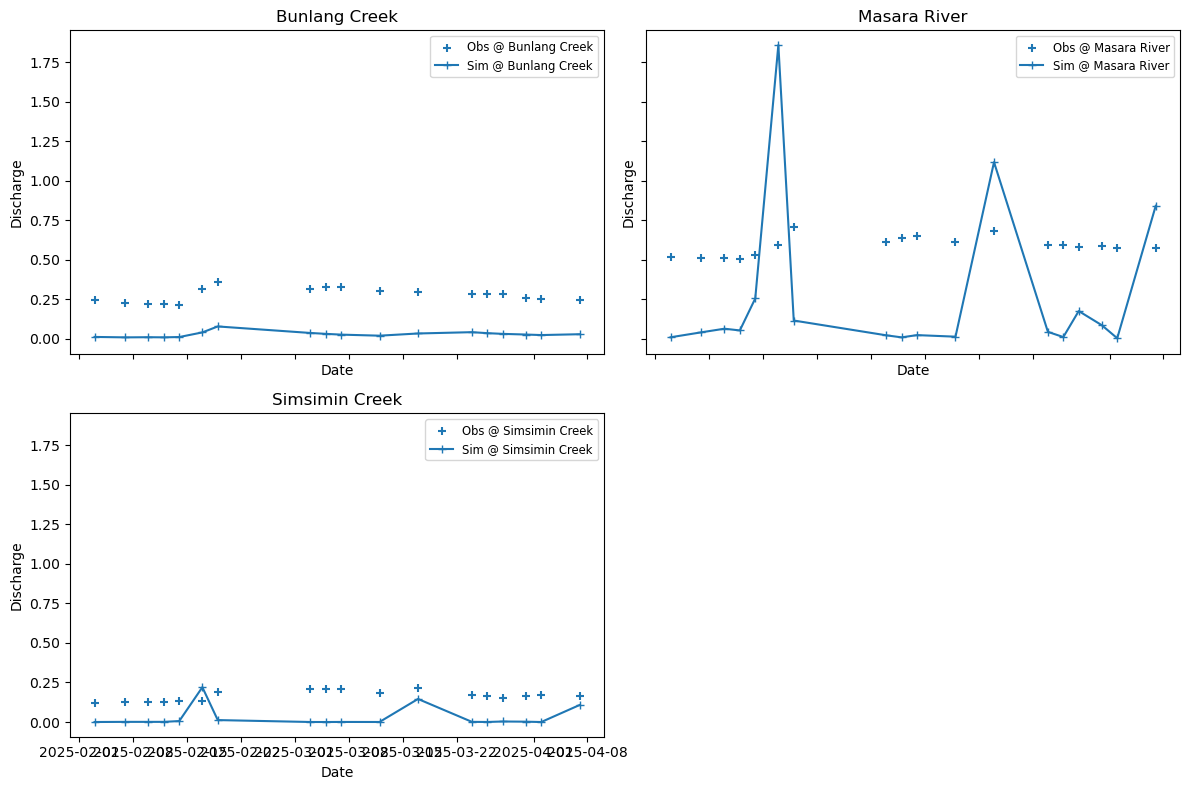

(<Figure size 1200x800 with 4 Axes>,
 <Axes: title={'center': 'Simsimin Creek'}, xlabel='Date', ylabel='Discharge'>)

In [239]:
# Read Observed Streamflow
df_obs = pd.read_excel(xl_path)

# Read Basin file then store the variables in a DataFrame
df = parse_subbasin_reach(hms_basin_path)
run_id = save_with_sequential_run_id(df)
df = pd.read_csv(csv_save_path)
print(run_id)
compute_nse_per_run(df=df, run_id=run_id)

plot_current_run(df=df)
